In [0]:
# Mounting Google Drive on Google Colab
""" Uncomment if working on Google Colab
from google.colab import drive
drive.mount('/content/drive',force_remount = True)
"""

In [0]:
# Importing libraries

import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.ndimage.interpolation import zoom
from IPython.display import display
from PIL import Image
import cv2

from keras.preprocessing import image
from keras.applications.vgg16 import VGG16

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")


In [0]:
# Checking tensorflow version to make sure it is between 1.13 and 1.15
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
print(tf.__version__)

1.15.0


In [0]:
# Initializing all paths - CHANGE BASE DIRECTORY W.R.T your file structure

base = r'/content/drive/My Drive/811Project/MM811'
image_path = os.path.join(base,'images')
image_path_all = os.path.join(base,'images_all')
image_path_add = os.path.join(base,'images_add')
path_to_code = os.path.join(base,'code')

In [0]:
# Importing all code dependencies
import sys
sys.path.insert(0,path_to_code)
from cam import GradCAM, GradCAMPlusPlus, SmoothGradCAMPlusPlus
from model import base_model_VGG16, new_model_InceptionV3, new_model_Xception
from utils import visualize,visualize_IG,visualize_IG_Image ,cam
from IntegratedGradients import integrated_gradients

# Part 2 : Novel Combination - Integrated CAMs

## Integrated SMG on VGG16

In [0]:
model1 = VGG16(include_top=True, weights='imagenet', input_shape=(224,224,3))
model1.compile(optimizer='sgd', loss='categorical_crossentropy') 

553467904/553467096 [==============================] - 5s 0us/step


### Fitting the classifier on Integrted Gradients

In [0]:
""" Don't re-run unless required
    Creating IG takes a bit of time
    All results are saved as numpy array for performing experiments
"""
ig  = integrated_gradients(model1)

Evaluated output channel (0-based index): All
Building gradient functions
Progress: 100.0%
Done.


### Creating Explanations

In [0]:
""" Don't re-run unless required
    Creating explanation maps need the previous cell to be run
    All results are saved as numpy array for performing experiments
"""
image_list = os.listdir(image_path)
exp_list = []

for images in image_list: 
    img = image.load_img(os.path.join(image_path,images), target_size=(224, 224))
    
    # preprocess image
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = vgg16.preprocess_input(x)

    # preprocess reference as well
    ref = np.zeros((224, 224, 3))
    ref = np.expand_dims(ref, axis=0)
    ref = vgg16.preprocess_input(ref)

    # Opening label file
    f = open(os.path.join(base,'human_readable_label.txt'),'r')
    labels = eval(f.read())
    f.close()

    pred = model1.predict(x)
    predicted = np.argmax(pred)
    #print("Predicted label:", labels[predicted])

    # Creating explanations for Integrated Gradients
    exp = ig.explain(x[0], reference=ref[0], outc=predicted)
    exp_list.append(exp)
    
    plt.figure(figsize=(4,2))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.xticks([], [])
    plt.yticks([], [])
    plt.title("Original image")
    plt.show()
    th = max(np.abs(np.min(exp)), np.abs(np.max(exp)))
    plt.subplot(1, 2, 2)
    plt.imshow(np.sum(exp, axis=2), cmap="seismic", vmin=-1*th, vmax=th)
    plt.xticks([], [])
    plt.yticks([], [])
    plt.title("Explanation")
    plt.show()

# Saving Explanation as numpy array for future experiments
count = 0 
for nparray in exp_list: 
  count += 1 
  np.save(os.path.join(base,"Intermediate_results/ExpList_IntegratedVGG"+str(count)),nparray)

### Visualizing Integrated Gradients on Pascal VOC data same as Grad-CAM++

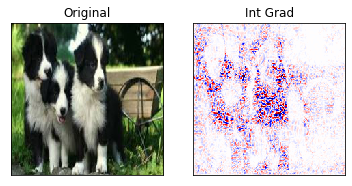

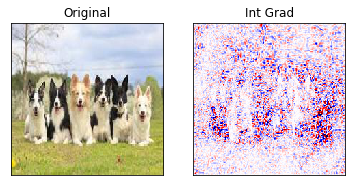

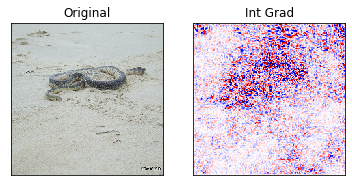

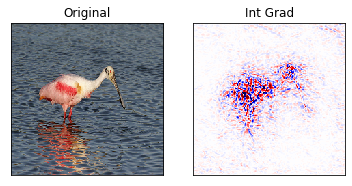

In [0]:
"""
Visualizing the explanation maps by integrated gradients on Pascal Voc data
"""
imagelist = os.listdir(image_path)
for i,images in zip(range(1,5),imagelist):

    # Loading the explanation maps from the pre-saved numpy array
    exp = np.load(os.path.join(base,"Intermediate_results/ExpList_IntegratedVGG"+str(i)+".npy"))
    img = image.load_img(os.path.join(image_path,images), target_size=(224, 224))
  
    th = max(np.abs(np.min(exp)), np.abs(np.max(exp)))
    plt.subplot(121)
    plt.imshow(img)
    plt.xticks([], [])
    plt.yticks([], [])
    plt.title("Original")
    plt.subplot(122)
    plt.imshow(np.sum(exp, axis=2), cmap="seismic", vmin=-1*th, vmax=th)
    plt.xticks([], [])
    plt.yticks([], [])
    plt.title("Int Grad")

    # Saving the comparison grid to local file
    plt.savefig(os.path.join(base,"Results/IntegratedGradients_"+"_"+images[:-4]+".png"))
    
    plt.show()

### Savings all CAMs for VGG16

In [0]:
image_list = os.listdir(image_path)
N_SAMPLES = 10
STD_DEV = 0.15
CAMs = [GradCAM,GradCAMPlusPlus,SmoothGradCAMPlusPlus]
CAM_names = ["GradCAM","GradCAMPP", "SMGradCAMPP"]

for images in image_list: 
    CAM_list=[]
    for j in range(len(CAMs)):
        #K.clear_session()
        img = image.load_img(os.path.join(image_path,images), target_size=(224, 224))
        X = image.img_to_array(img)
        X = np.expand_dims(X, axis=0)

        base_model, target_layer, prediction, decoded_y = base_model_VGG16(X)
        CAM_function = CAMs[j]
        if j == 2:
            CAM = cam(CAM_function,base_model,target_layer,prediction,X,N_SAMPLES,STD_DEV)
        else:
            CAM = cam(CAM_function,base_model,target_layer,prediction,X)
        CAM_list.append(CAM)    
        
    count = 0
    for nparray in CAM_list:
        np.save(os.path.join(base,"Intermediate_results/CAM_VGG_"+images+"_"+CAM_names[count]), nparray) 
        count += 1

## Integrated CAMs - First Experiment (Direct Combination)

Integrated Gradients Experiment 1 : 
_____________________________________

Class Activating Mapping for  collies  using VGG16


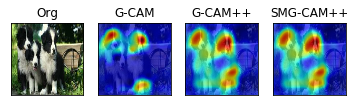

Direct Combination of Integrated Gradients X CAMs for  collies


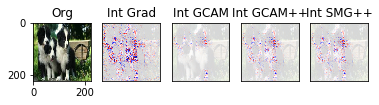

Class Activating Mapping for  multiple_dogs  using VGG16


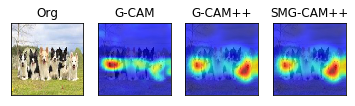

Direct Combination of Integrated Gradients X CAMs for  multiple_dogs


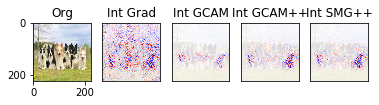

Class Activating Mapping for  snake  using VGG16


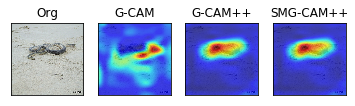

Direct Combination of Integrated Gradients X CAMs for  snake


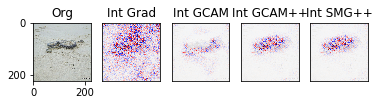

Class Activating Mapping for  waterbird  using VGG16


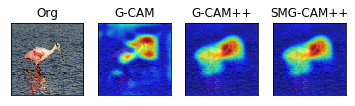

Direct Combination of Integrated Gradients X CAMs for  waterbird


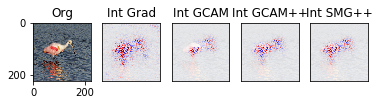

In [0]:
image_list = os.listdir(image_path)
CAM_names = ["GradCAM","GradCAMPP", "SMGradCAMPP"]
i=1
print("Integrated Gradients Experiment 1 : ")
print("_____________________________________\n")
for images in image_list: 
    img = image.load_img(os.path.join(image_path,images), target_size=(224, 224))
    # ALL CAMS
    gradCAM_VGG16 = np.load(os.path.join(base,"Intermediate_results/CAM_VGG_"+images+"_"+CAM_names[0]+".npy"))
    gradCAMPP_VGG16 = np.load(os.path.join(base,"Intermediate_results/CAM_VGG_"+images+"_"+CAM_names[1]+".npy"))
    smoothgradCAMPP_VGG16 = np.load(os.path.join(base,"Intermediate_results/CAM_VGG_"+images+"_"+CAM_names[2]+".npy"))
      
    
    print("Class Activating Mapping for ", images[:-4]," using VGG16")
    
    # Visualizing results
  
    comparison_grid = visualize(img,gradCAM_VGG16,gradCAMPP_VGG16,smoothgradCAMPP_VGG16,0.7)
    comparison_grid.savefig(os.path.join(base,"Results/IntegratedGradients/CAM_Reference_"+images[:-4]+".png"))
    comparison_grid.show()
    
    
    """ COMBINATION OF IG & CAMS """
    print("Direct Combination of Integrated Gradients X CAMs for ", images[:-4])
    exp = np.load(os.path.join(base,"ExpList_IntegratedVGG"+str(i)+".npy"))
    th = max(np.abs(np.min(exp)), np.abs(np.max(exp))) 
    ig_vis = np.sum(exp, axis=2)
    ig_g = np.multiply(gradCAM_VGG16,ig_vis)
    ig_gp  = np.multiply(gradCAMPP_VGG16,ig_vis)
    ig_smg = np.multiply(smoothgradCAMPP_VGG16,ig_vis)
    
    comparison_grid = visualize_IG(img,ig_vis,ig_g,ig_gp,ig_smg,th,"Int", 0.85,"seismic")
    comparison_grid.savefig(os.path.join(base,"Results/IntegratedGradients/IG_CAM_"+images[:-4]+".png"))
    comparison_grid.show()    
    i += 1
    

## Integrated CAM - Second Experiment (Indirect)

Integrated Gradients Experiment 2 : 
_____________________________________
Class activation map for  collies  using VGG16
ALL CAMS


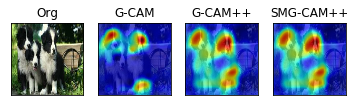

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 COMBINATION OF PRODUCT OF (IMG,IG) MULTIPLIED WITH CAMS
 


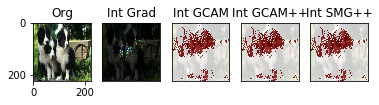

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


COMBINATION OF PRODUCT OF (COLR_IMG, IG)  BLENDED WITH CAMS



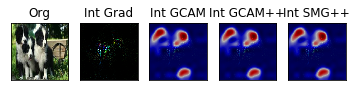

Class activation map for  multiple_dogs  using VGG16
ALL CAMS


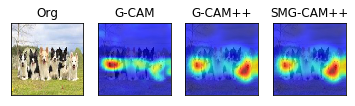

 COMBINATION OF PRODUCT OF (IMG,IG) MULTIPLIED WITH CAMS
 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


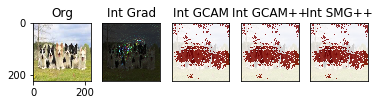

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


COMBINATION OF PRODUCT OF (COLR_IMG, IG)  BLENDED WITH CAMS



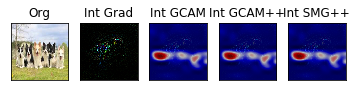

Class activation map for  snake  using VGG16
ALL CAMS


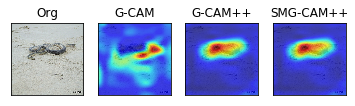

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 COMBINATION OF PRODUCT OF (IMG,IG) MULTIPLIED WITH CAMS
 


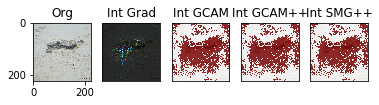

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


COMBINATION OF PRODUCT OF (COLR_IMG, IG)  BLENDED WITH CAMS



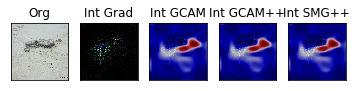

Class activation map for  waterbird  using VGG16
ALL CAMS


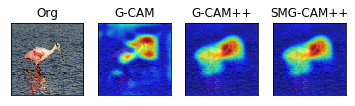

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 COMBINATION OF PRODUCT OF (IMG,IG) MULTIPLIED WITH CAMS
 


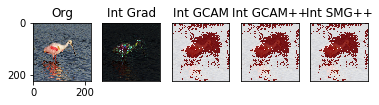

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


COMBINATION OF PRODUCT OF (COLR_IMG, IG)  BLENDED WITH CAMS



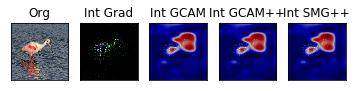

In [0]:
image_list = os.listdir(image_path)
CAM_names = ["GradCAM","GradCAMPP", "SMGradCAMPP"]
i=1
print("Integrated Gradients Experiment 2 : ")
print("_____________________________________")
for images in image_list: 
    img = image.load_img(os.path.join(image_path,images), target_size=(224, 224))
    # ALL CAMS
    gradCAM_VGG16 = np.load(os.path.join(base,"CAM_VGG_"+images+"_"+CAM_names[0]+".npy"))
    gradCAMPP_VGG16 = np.load(os.path.join(base,"CAM_VGG_"+images+"_"+CAM_names[1]+".npy"))
    smoothgradCAMPP_VGG16 = np.load(os.path.join(base,"CAM_VGG_"+images+"_"+CAM_names[2]+".npy"))
      
    print("Class activation map for ", images[:-4]," using VGG16")
    
    # Visualizing results
    print("ALL CAMS")
    comparison_grid = visualize(img,gradCAM_VGG16,gradCAMPP_VGG16,smoothgradCAMPP_VGG16,0.7)
    comparison_grid.show()
    

    """ COMBINATION OF PRODUCT OF (IMG,IG) MULTIPLIED WITH CAMS """
    
    #exp = np.load("ExpList_IntegratedVGG"+str(i)+".npy")
    th = max(np.abs(np.min(exp)), np.abs(np.max(exp))) 

    img_ig = np.multiply(exp,img)
    img_ig_g = (np.multiply(gradCAM_VGG16,np.sum(img_ig,axis=2))*255).astype(np.uint8)
    img_ig_gp  = (np.multiply(gradCAM_VGG16,np.sum(img_ig,axis=2))*255).astype(np.uint8)
    img_ig_smg = (np.multiply(gradCAM_VGG16,np.sum(img_ig,axis=2))*255).astype(np.uint8)
    print(" COMBINATION OF PRODUCT OF (IMG,IG) MULTIPLIED WITH CAMS\n ")
    comparison_grid = visualize_IG(img,img_ig,img_ig_g,img_ig_gp,img_ig_smg,th,"Int",0.8,"seismic")
    comparison_grid.savefig(os.path.join(base,"Results/IntegratedGradients/IG_X_Color_X_CAM_"+images[:-4]+".png"))
    comparison_grid.show()
    
    
    """COMBINATION OF PRODUCT OF (COLR_IMG, IG)  BLENDED WITH CAMS"""
    
    img_ig = np.multiply(exp,img)
    print("COMBINATION OF PRODUCT OF (COLR_IMG, IG)  BLENDED WITH CAMS\n")
    comparison_grid = visualize_IG_Image(img,img_ig,gradCAM_VGG16,gradCAM_VGG16,gradCAM_VGG16,th,"Int",0.7,"seismic")
    comparison_grid.savefig(os.path.join(base,"Results/IntegratedGradients/IG_X_Color_+_CAM_"+images[:-4]+".png"))
    comparison_grid.show()
    i += 1